In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor

c:\Users\riven\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\riven\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\riven\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv("Predict_ready_df")

In [3]:
df.drop(df[df['idle_time']==0].index,inplace= True)

In [4]:
df

,Unnamed: 0,timestamp,station_id,bike_id,idle_time,bike_count,temperature,windspeed,rain,hour,IsWeekday,month,lat,lon,near_bus_station,near_school,near_leisure_spots
0,1,2019-01-01 09:00:00,3,2191,113.283333,1,10.0,30.0,0,9,1,1,37.78638,-122.40490,0,0,1
1,2,2019-01-01 09:00:00,3,5063,107.800000,2,10.0,30.0,0,9,1,1,37.78638,-122.40490,0,0,1
2,3,2019-01-01 09:00:00,3,5262,98.400000,3,10.0,30.0,0,9,1,1,37.78638,-122.40490,0,0,1
3,4,2019-01-01 10:00:00,3,5354,31.116667,4,9.0,37.0,0,10,1,1,37.78638,-122.40490,0,0,1
4,5,2019-01-01 10:00:00,3,4760,25.700000,5,9.0,37.0,0,10,1,1,37.78638,-122.40490,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130983,3132765,2019-12-23 17:00:00,498,12424,1.083333,2,10.0,6.0,0,17,1,12,37.72589,-122.45244,0,1,1
3130984,3132766,2019-12-23 17:00:00,498,353685,975.483333,2,10.0,6.0,0,17,1,12,37.72589,-122.45244,0,1,1
3130985,3132767,2019-12-24 10:00:00,498,10310,196.016667,2,8.0,15.0,0,10,1,12,37.72589,-122.45244,0,1,1
3130986,3132768,2019-12-30 14:00:00,498,10962,0.383333,1,9.0,11.0,0,14,1,12,37.72589,-122.45244,0,1,1


# Transform cyclic features

In [5]:
df.timestamp = pd.to_datetime(df['timestamp'],format ='%Y-%m-%d %H:%M:%S')

In [6]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
start_date = '2019-01-01'
end_date = '2019-12-31'
holidays = cal.holidays(start=start_date, end=end_date)



In [7]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day

# Create a new 'date' column with the timestamp
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [8]:
df['IsHoliday'] = (df['date'].isin(holidays)).astype(int)

In [9]:
df.drop(['year','day'],axis = 1,inplace= True)

In [10]:

from sklearn.preprocessing import OneHotEncoder


# Define the mapping of months to seasons
season_mapping = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Autumn',
    10: 'Autumn',
    11: 'Autumn',
    12: 'Winter'
}

# Map the month values to seasons using the defined mapping
df['season'] = df['month'].map(season_mapping)

# Perform one-hot encoding on the 'season' column
encoder = OneHotEncoder(sparse=False)
df['season'] = encoder.fit_transform(df[['season']])






c:\Users\riven\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

hour_arr = np.array(df['hour'])
month_arr = np.array(df['month'])


df['hour_sin'] = sin_transformer(24).fit_transform(hour_arr.reshape(-1,1))
df['hour_cos'] = cos_transformer(24).fit_transform(hour_arr.reshape(-1,1))
df['month_sin'] = sin_transformer(12).fit_transform(month_arr.reshape(-1,1))
df['month_cos'] = cos_transformer(12).fit_transform(month_arr.reshape(-1,1))


# Remove outlier

In [12]:
# Assuming you have a DataFrame named 'df' and want to remove outliers from column 'column_name'

# Calculate the z-scores for each value in the column
z_scores = np.abs((df['idle_time'] - df['idle_time'].mean()) / df['idle_time'].std())

# Define a threshold for outliers (e.g., z-score > 3)
threshold = 1.5

# Create a boolean mask indicating the outliers
outliers_mask = z_scores > threshold

# Remove outliers from the column by replacing them with NaN values
df.loc[outliers_mask, 'idle_time'] = np.nan

# Return the modified column back to the original DataFrame
df = df.dropna(subset=['idle_time']) # Replace NaN values with median or any other desired method

In [13]:
df.shape

(3076850, 24)

In [14]:
features =['idle_time',
       'bike_count', 'temperature', 'windspeed', 'rain', 'hour', 'IsWeekday',
       'month','near_bus_station', 'near_school',
       'near_leisure_spots', 'hour_sin', 'hour_cos', 'IsHoliday',
       'season']

used = df[features]

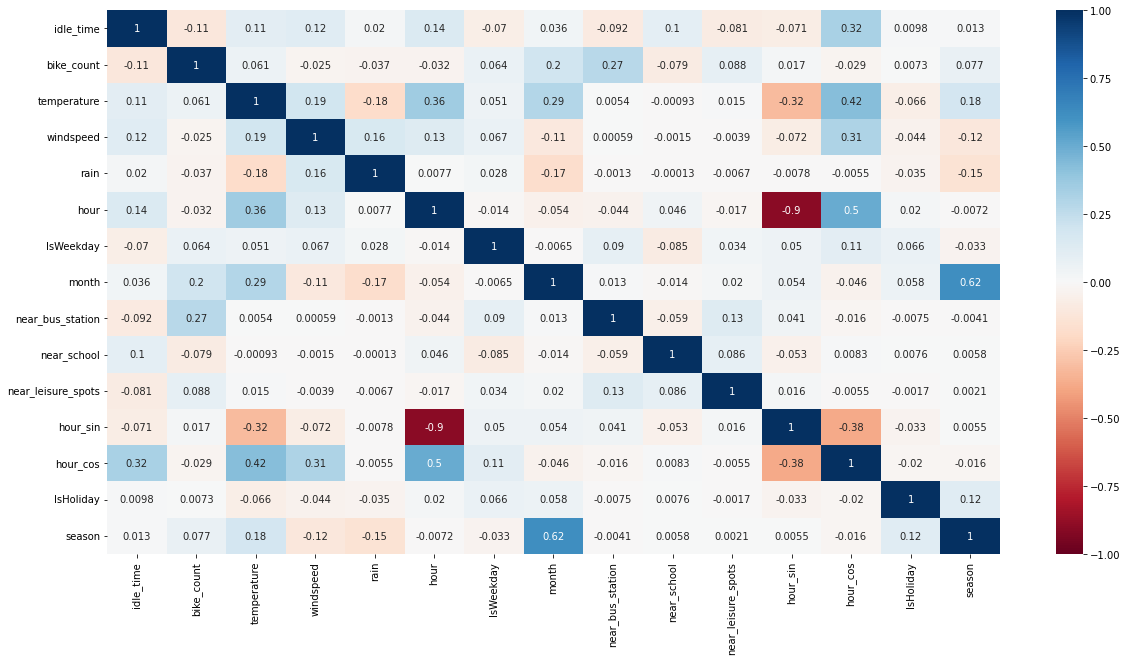

In [15]:
plt.figure(figsize=(20, 10))
corr = used.corr()
# Create the heatmap
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)
plt.show()

In [16]:
xp = df[['bike_count', 'temperature', 'windspeed', 'hour_sin', 'hour_cos','month_sin','month_cos', 'rain', 'IsWeekday',
       'near_bus_station', 'near_school',
       'near_leisure_spots','IsHoliday','season'
       ]].values

yp= df['idle_time'].values

In [17]:
sample_set = df[['bike_count', 'temperature', 'windspeed', 'hour_sin', 'hour_cos','month_sin','month_cos', 'rain', 'IsWeekday',
       'near_bus_station', 'near_school',
       'near_leisure_spots','IsHoliday','season','idle_time'
       ]].values

In [19]:
sample_size = 30000
random_indices = np.random.choice(sample_set.shape[0], size=sample_size, replace=False)
sample = sample_set[random_indices,:]

xs = sample[:,:14]
ys = sample[:,14:]

In [53]:
X_train_val, X_test, y_train_val, y_test = train_test_split(xp, yp, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

Scaling features

In [20]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
# X_train[:,:3] = scaler.fit_transform(X_train[:,:3])
# X_test[:,:3] = scaler.transform(X_test[:,:3])
# X_val[:,:3] = scaler.transform(X_val[:,:3])

xs[:,:3] = scaler.fit_transform(xs[:,:3])


In [84]:
xs.shape

(10000, 14)

In [21]:
from sklearn.preprocessing import PolynomialFeatures
degree = 7
poly = PolynomialFeatures(degree= degree,include_bias= False)
# poly_fts_train = poly.fit_transform(X_train[:,:5])
# poly_fts_test = poly.transform(X_test[:,:5])
# poly_fts_val = poly.transform(X_val[:,:5])

poly_fts_xs = poly.fit_transform(xs[:,:7])




In [22]:
# non_poly_train = X_train[:,5:]
# non_poly_test = X_test[:,5:]
# non_poly_val = X_val[:,5:]

non_poly_xs = xs[:,7:]



In [23]:
# poly_train = np.concatenate((poly_fts_train,non_poly_train),axis =1)
# poly_test = np.concatenate((poly_fts_test,non_poly_test),axis =1)
# poly_val = np.concatenate((poly_fts_val,non_poly_val),axis =1)

poly_xs = np.concatenate((poly_fts_xs,non_poly_xs),axis =1)

In [24]:
poly_xs.shape

(30000, 3438)

In [54]:

# define base model

 # create model
model = Sequential()
model.add(Dense(10, input_shape=(126,), kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))




model.add(Dense(1, kernel_initializer='normal'))
 # Compile model
model.compile(loss='mean_squared_error', optimizer='adam'
             )


In [55]:
model.fit(poly_xs,ys, batch_size =32, epochs = 50)

Epoch 1/50
313/313 [==============================] - 2s 2ms/step - loss: 19073.0625
Epoch 2/50
313/313 [==============================] - 1s 2ms/step - loss: 15718.6240
Epoch 3/50
313/313 [==============================] - 1s 2ms/step - loss: 14755.4590
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: 14187.1631
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: 13924.9150
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 13759.3779
Epoch 7/50
313/313 [==============================] - 1s 3ms/step - loss: 13684.6094
Epoch 8/50
313/313 [==============================] - 1s 2ms/step - loss: 13634.7666
Epoch 9/50
313/313 [==============================] - 1s 2ms/step - loss: 13577.8398
Epoch 10/50
313/313 [==============================] - 1s 2ms/step - loss: 13534.0752
Epoch 11/50
313/313 [==============================] - 1s 2ms/step - loss: 13508.1836
Epoch 12/50
313/313 [==============================] - 1s 2ms/s

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))


In [25]:
# we use linear regression as a base!!! ** sometimes misunderstood **
regression_model = LinearRegression()

regression_model.fit(poly_xs, ys)
print(regression_model.coef_ ,regression_model.intercept_)
regression_model.coef_
regression_model.intercept_


[[-57.43154583 209.30994997  32.46986626 ... -23.05809227   6.1484855
   24.7568291 ]] [-64.83158259]


array([-64.83158259])

In [63]:
from sklearn.linear_model import Ridge

# initialize model
model_L2 = Ridge(alpha = 0.1, solver = 'lsqr') # select least squares regression as solver

# train model
model_L2.fit(poly_xs, ys)


print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [-2.58649653e+01 -5.30123554e+00  2.39626861e+00 -1.55524645e+00
  7.53157049e+01  1.25670010e+01 -6.79614630e+00 -1.89164082e+00
  3.94947040e+00 -1.53660264e+01 -1.68590178e+00 -1.49988667e+00
  3.99958488e-02  2.32884966e+00 -5.68472719e-01 -8.22118789e-02
  4.44567769e+00 -5.30332519e+01 -6.66456168e+00  5.30332519e+01
 -1.19035167e+00  1.36051593e+00  4.08883492e-01 -2.07861953e-01
  1.40630753e+00  3.58887701e-01  4.82335151e-02  1.27595707e-01
 -3.59607384e+00 -2.02401991e-01 -1.99103057e-01 -1.19476344e+00
 -1.10184709e+01  9.17205808e+00 -1.48464944e+01  6.35527069e-01
 -1.15323546e+00  7.78799453e-01  1.13305312e-01  5.98522262e-01
 -2.95078179e+00  1.34299590e+00 -1.74829954e+00  3.54400918e+00
 -3.55293600e+00 -3.79148400e-02  7.04825806e-01 -1.71370058e+00
 -1.79009901e+00  3.59736649e+00  4.18636762e+00  2.88592607e+00
  2.71041071e+01 -4.44117252e+00  4.82115978e+01 -1.99446294e+01
  5.21748890e+00  1.68153184e+01 -1.31829963e+01 -1.43079343e+01
  4.0764434

In [40]:
from sklearn.linear_model import Lasso

model_L1 = Lasso(alpha = 0.001)

model_L1.fit(poly_xs, ys)

print("Coefficients ", model_L1.coef_, "\nIntercept ", model_L1.intercept_ )

Coefficients  [-10.94109817  11.67884208   7.24108358 ... -18.81970645  12.5681727
  -6.3859745 ] 
Intercept  [169.53487577]


c:\Users\riven\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.404e+07, tolerance: 1.552e+04
  model = cd_fast.enet_coordinate_descent(


In [85]:
poly_val.shape

(4156794, 3)

In [17]:
def plot_L2_regression_performance ():

    err_train = []
    err_cv = []
    
    

    for alpha in np.logspace(-20,-10,20):

        
        
        

        # fit model
        model_L2 = Ridge(alpha = alpha, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(poly_x, y_train)
    
        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(poly_x), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(poly_val), y_val))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-20,-10,20), err_train, np.logspace(-20,-10,20), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

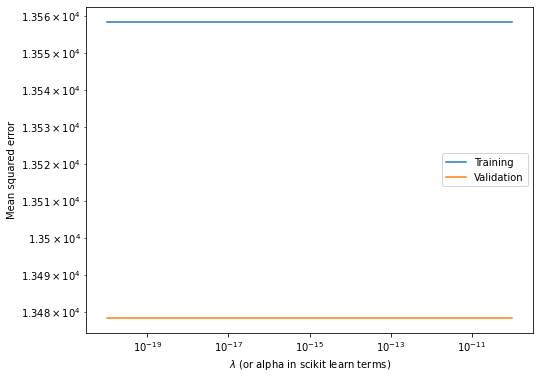

In [18]:
plot_L2_regression_performance()

In [27]:

train_pred = regression_model.predict(poly_xs)
print("Test set performance:")

print("MAE:",mean_absolute_error(ys, train_pred))
print("RMSE:",(mean_squared_error(ys, train_pred))**(0.5))  
print("R2:",r2_score(ys, train_pred))

Test set performance:
MAE: 60.94227273864033
RMSE: 109.94255876342449
R2: 0.2774316674639161


In [33]:
train_pred.max()

372.8500475657638